In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch

np.random.seed(0)
torch.manual_seed(0)

In [3]:
from tslearn.datasets import UCR_UEA_datasets

# Load dataset (Replace 'DatasetName' with your actual dataset)
ucr = UCR_UEA_datasets(use_cache=True)
X_train, y_train, X_test, y_test = ucr.load_dataset(
    "UWaveGestureLibrary"
)  # Good dataset : Epilepsy, UWaveGestureLibrary, HandMovementDirection

X_train.shape

(120, 315, 3)

In [4]:
from sklearn.preprocessing import MinMaxScaler

batch_size, seq_len, n_dim = X_train.shape
test_batch_size = X_test.shape[0]

scl = MinMaxScaler()

X_train_reshaped = X_train.reshape(-1, n_dim)
X_test_reshaped = X_test.reshape(-1, n_dim)

X_train_scaled = scl.fit_transform(X_train_reshaped)
X_test_scaled = scl.transform(X_test_reshaped)

X_train = X_train_scaled.reshape(batch_size, seq_len, n_dim)
X_test = X_test_scaled.reshape(test_batch_size, seq_len, n_dim)

In [5]:
y_train = y_train.astype(float).astype(int)
y_test = y_test.astype(float).astype(int)

In [6]:
import sys

sys.path.append("..")

In [7]:
from torch_mas.batch.trainer import BaseTrainer
from torch_mas.batch.internal_model import NClass
from torch_mas.batch.activation_function import BaseActivation
from torch_mas.data import DataBuffer

_, seq_len, input_dim = X_train.shape

internal_nodel = NClass(
    input_dim=input_dim,
    output_dim=1,
    memory_length=input_dim + 1,
)

activation = BaseActivation(
    seq_len=seq_len, input_dim=input_dim, output_dim=1, alpha=0.1, neighbor_rate=0.9
)

trainer = BaseTrainer(
    activation,
    internal_nodel,
    R=0.1,
    bad_th=0.01,
    n_epochs=10,
)

dataset = DataBuffer(X_train, y_train)

trainer.fit(dataset)
trainer.n_agents

120

In [8]:
import torch
from sklearn.metrics import accuracy_score

y_pred = trainer.predict(torch.tensor(X_test, dtype=torch.float32))
print(accuracy_score(y_pred[~torch.isnan(y_pred)], y_test[~torch.isnan(y_pred)]))

0.884375


tensor(3.) green
tensor(1.) red
tensor(4.) purple
tensor(4.) purple
tensor(1.) red


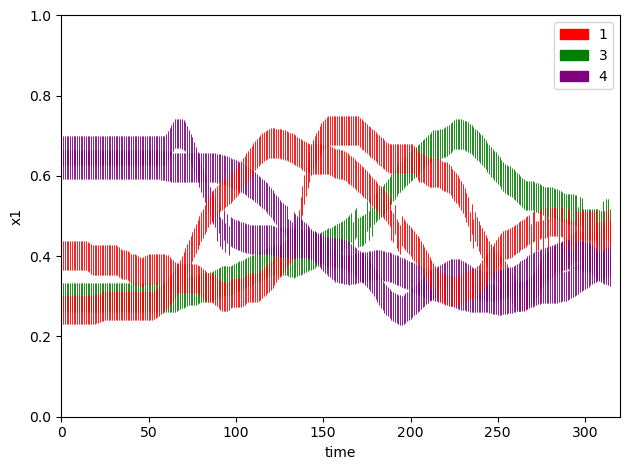

In [9]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as mpatches


fig, ax = plt.subplots()
colors = ["red", "blue", "green", "purple", "orange", "grey", "magenta", "brown"]

# activation.orthotopes is a tensor of size (n_agents, seq_len, n_dim, 2)
orthotopesdim0 = activation.orthotopes[:5, :, 0, :]

for agent_id in range(orthotopesdim0.shape[0]):
    y = internal_nodel.base_prediction[agent_id]
    print(y, colors[int(y - 1)])

    lines = []
    for time in range(orthotopesdim0[agent_id].shape[0]):
        for h in range(orthotopesdim0[agent_id][time].shape[0]):
            lines.append(
                [
                    (time, orthotopesdim0[agent_id][time][0]),
                    (time, orthotopesdim0[agent_id][time][1]),
                ]
            )

    lc = LineCollection(lines, colors=colors[int(y - 1)], linewidths=0.5, alpha=0.9)
    ax.add_collection(lc)

ax.set_xlim(0, 320)
plt.xlabel("time")
plt.ylabel("x1")
red_patch = mpatches.Patch(color="red", label="1")
green_patch = mpatches.Patch(color="green", label="3")
orange_patch = mpatches.Patch(color="purple", label="4")
ax.legend(handles=[red_patch, green_patch, orange_patch])
plt.tight_layout()
plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/ciel/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


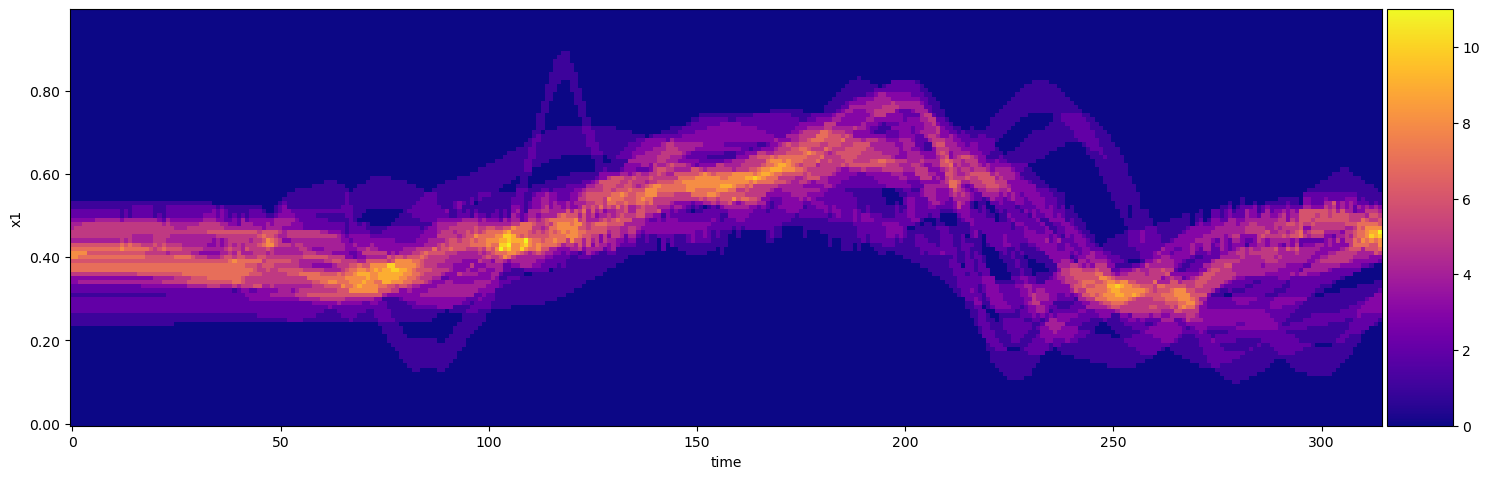

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker


orthotopes = trainer.activation.orthotopes
base_prediction = trainer.internal_model.base_prediction


def intersect_point(hypercube, x):
    return (x < hypercube[1]) & (x > hypercube[0])


batch_intersect_point = torch.vmap(intersect_point, in_dims=(0, None))


def create_heatmap(fig, ax, dim, orthotopes):
    heatmap = torch.zeros((100, 315))
    x = torch.arange(0, 100)
    y = torch.arange(0, 315)
    xx, yy = torch.meshgrid(x, y)
    zz = torch.stack((xx, yy), dim=-1).flatten(start_dim=0, end_dim=1)

    for x, y in zz:
        orthotopes_ts = orthotopes[:, y]
        heatmap[x, y] += batch_intersect_point(
            orthotopes_ts[:, dim][base_prediction == 1], x / 100
        ).sum()

    im = ax.imshow(heatmap, cmap="plasma", interpolation="nearest", origin="lower")
    # ax.set_title(f"{dim}")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax, orientation="vertical")
    ax.set_xlabel("time")
    ax.set_ylabel("x1")

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f"{y/100:.2f}"))


fig, axs = plt.subplots(1, 1, figsize=(15, 10))
# for dim in range(orthotopes.size(2)):
# create_heatmap(fig, axs[dim], dim, orthotopes)

create_heatmap(fig, axs, 0, orthotopes)
plt.tight_layout()
plt.show()